In [1]:
import pandas as pd
import numpy as np
from snn import Entity, Relation, SNN
from snn.utils import print_model, draw

Using Theano backend.
Using cuDNN version 7101 on context None
Mapped name None to device cuda0: GeForce MX150 (0000:01:00.0)


In [2]:
Person = Entity("Person")
Movie = Entity("Movie")

In [3]:
df = pd.read_csv("../data/IMDB/relations.tsv.gz", sep="\t", names=['Movie', 'Relation', 'Person'], nrows=100211)

In [4]:
df.head()

,Movie,Relation,Person
0,Carmencita,self,Carmencita
1,Carmencita,director,William K.L. Dickson
2,Carmencita,cinematographer,William Heise
3,Le clown et ses chiens,director,Émile Reynaud
4,Le clown et ses chiens,composer,Gaston Paulin


In [5]:
relations = {l: Relation(label=l, dst=Person, src=Movie) for l in df['Relation'].unique() if l!='self'}
relations

{'director': director(<Movie> , <Person>),
 'cinematographer': cinematographer(<Movie> , <Person>),
 'composer': composer(<Movie> , <Person>),
 'producer': producer(<Movie> , <Person>),
 'editor': editor(<Movie> , <Person>),
 'actor': actor(<Movie> , <Person>),
 'actress': actress(<Movie> , <Person>),
 'writer': writer(<Movie> , <Person>),
 'production_designer': production_designer(<Movie> , <Person>),
 'archive_footage': archive_footage(<Movie> , <Person>)}

In [6]:
entities = [Person, Movie]
entities

[<Person>, <Movie>]

In [7]:
X = [t.Person + " @ " + t.Movie for t in df.itertuples() if t.Relation!='self']
y = [[relations[t.Relation]] for t in df.itertuples() if t.Relation!='self']
person = [t.Person for t in df.itertuples() if t.Relation!='self']
movie = [t.Movie for t in df.itertuples() if t.Relation!='self']

In [8]:
print(len(person), len(movie))

100000 100000


In [9]:
from sklearn.feature_extraction.text import CountVectorizer

In [10]:
cv = CountVectorizer(dtype='int32')
Xt = cv.fit_transform(X)

In [11]:
instances = sorted(list(set(person+movie)))

## Contruyendo el embeding de entidadas

In [12]:
emb_m = SNN.build_embeding(cv, instances, check=False)

In [13]:
emb_m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 21797)             0         
_________________________________________________________________
entity_embeding_1 (EntityEmb (None, 30924)             0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


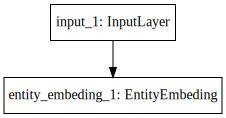

In [14]:
draw(emb_m)

In [15]:
Xte = emb_m.predict(Xt, verbose=1)

100000/100000 [==============================] - 74s 738us/step


## Entrnando la snn completa

In [16]:
from keras.layers import Input

In [17]:
x = Input(shape=(emb_m.output_shape[1],), sparse=True)
snn = SNN(entities=entities, relations=relations.values(), entity_shape=32, relation_shape=64)
output = snn(x)

In [18]:
snn_model = snn.build(x)

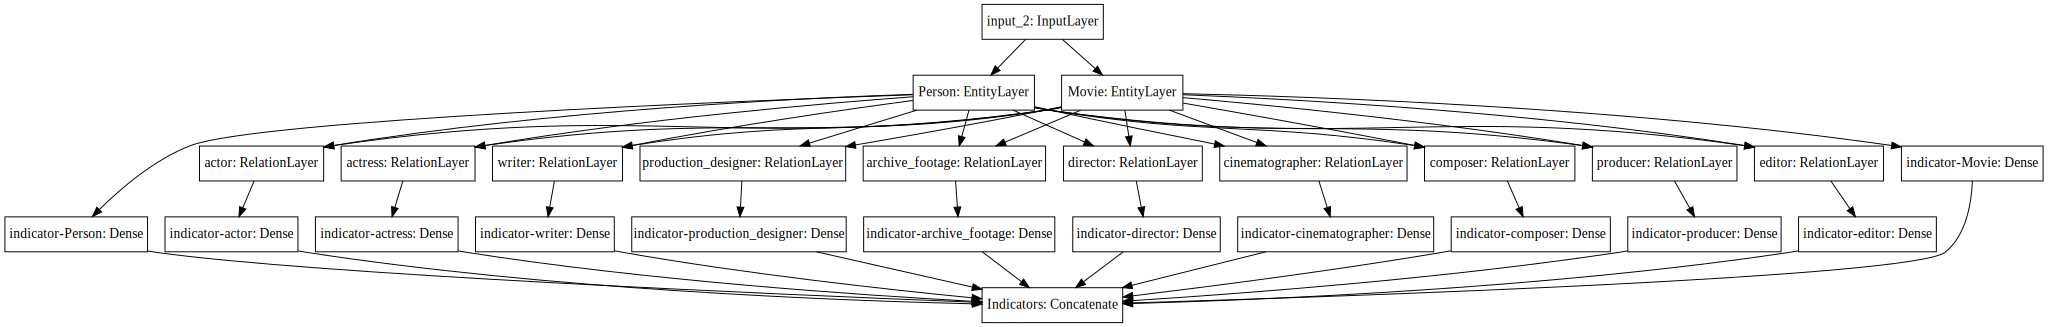

In [19]:
draw(snn_model)

In [20]:
snn_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 30924)        0                                            
__________________________________________________________________________________________________
Person (EntityLayer)            (None, 32)           990656      input_2[0][0]                    
__________________________________________________________________________________________________
Movie (EntityLayer)             (None, 32)           990656      input_2[0][0]                    
__________________________________________________________________________________________________
director (RelationLayer)        (None, 64)           6272        Movie[0][0]                      
                                                                 Person[0][0]                     
__________

In [21]:
yp = snn_model.predict(Xte, verbose=1)
yp = (yp > 0.5).astype(int)
yp

100000/100000 [==============================] - 49s 491us/step


array([[1, 0, 0, ..., 1, 1, 0],
       [1, 0, 0, ..., 1, 1, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 0, 1]])

In [22]:
yt = snn.map(y)
yt

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
(yp == yt).mean()

0.5275408333333333

In [24]:
snn_model.fit(Xte, yt, epochs=10, validation_split=0.1)

Train on 90000 samples, validate on 10000 samples
Epoch 1/10
90000/90000 [==============================] - 97s 1ms/step - loss: 0.2115 - acc: 0.9337 - val_loss: 0.1697 - val_acc: 0.9354
Epoch 2/10
90000/90000 [==============================] - 96s 1ms/step - loss: 0.1782 - acc: 0.9530 - val_loss: 0.1640 - val_acc: 0.9451
Epoch 3/10
90000/90000 [==============================] - 95s 1ms/step - loss: 0.1482 - acc: 0.9625 - val_loss: 0.1644 - val_acc: 0.9511
Epoch 4/10
90000/90000 [==============================] - 96s 1ms/step - loss: 0.1315 - acc: 0.9674 - val_loss: 0.1730 - val_acc: 0.9450
Epoch 5/10
90000/90000 [==============================] - 96s 1ms/step - loss: 0.1559 - acc: 0.9677 - val_loss: 0.1727 - val_acc: 0.9516
Epoch 6/10
90000/90000 [==============================] - 97s 1ms/step - loss: 0.1603 - acc: 0.9687 - val_loss: 0.1588 - val_acc: 0.9563
Epoch 7/10
90000/90000 [==============================] - 98s 1ms/step - loss: 0.1505 - acc: 0.9700 - val_loss: 0.1818 - val_acc

In [25]:
yp = snn_model.predict(Xte, verbose=1)
yp = (yp > 0.5).astype(int)
yp

100000/100000 [==============================] - 45s 448us/step


array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [26]:
(yp == yt).mean()

0.9713283333333333

In [27]:
snn_model.save('../data/snn_model.model')

## Entrenar entidades por separado

In [28]:
from snn.layers import EntityLayer, RelationLayer
from keras.models import Model
from keras.layers import Dense
from random import shuffle

## Entrnando las entidades

### Entrenando entidad Person

In [29]:
x = Input(shape=(emb_m.output_shape[1],), sparse=True)
Person_e=EntityLayer(snn.entity_shape, name=Person.name)(x)
Person_i=Dense(units=1, activation='sigmoid', name="indicator-%s" % Person.name)(Person_e)
Person_m = Model(inputs=x, outputs=Person_i)
Person_m.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

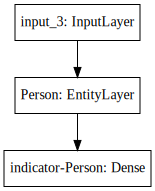

In [30]:
draw(Person_m)

In [31]:
tt = list(zip(person,[1]*len(person)))+list(zip(movie,[0]*len(movie)))
shuffle(tt)
Xt11 = cv.transform(list(map( lambda x: x[0],tt)))
Xt1 = emb_m.predict(Xt11, verbose=1)
yt1 = np.asarray(list(map( lambda x: [x[1]],tt))).astype(int)

200000/200000 [==============================] - 116s 578us/step


In [32]:
Person_m.fit(Xt1, yt1, epochs=10, validation_split=0.1)

Train on 180000 samples, validate on 20000 samples
Epoch 1/10
180000/180000 [==============================] - 55s 305us/step - loss: 0.1850 - acc: 0.9481 - val_loss: 0.1083 - val_acc: 0.9808
Epoch 2/10
180000/180000 [==============================] - 55s 305us/step - loss: 0.0832 - acc: 0.9856 - val_loss: 0.0806 - val_acc: 0.9845
Epoch 3/10
180000/180000 [==============================] - 55s 305us/step - loss: 0.0687 - acc: 0.9872 - val_loss: 0.0748 - val_acc: 0.9838
Epoch 4/10
180000/180000 [==============================] - 55s 305us/step - loss: 0.0656 - acc: 0.9877 - val_loss: 0.0750 - val_acc: 0.9860
Epoch 5/10
180000/180000 [==============================] - 55s 305us/step - loss: 0.0638 - acc: 0.9879 - val_loss: 0.0721 - val_acc: 0.9852
Epoch 6/10
180000/180000 [==============================] - 55s 305us/step - loss: 0.0608 - acc: 0.9885 - val_loss: 0.0707 - val_acc: 0.9870
Epoch 7/10
180000/180000 [==============================] - 55s 305us/step - loss: 0.0593 - acc: 0.9888

In [33]:
yp = Person_m.predict(Xt1, verbose=1)
yp = (yp > 0.5).astype(int)
yp

200000/200000 [==============================] - 35s 176us/step


array([[0],
       [1],
       [1],
       ...,
       [0],
       [1],
       [0]])

In [34]:
(yp == yt1).mean()

0.99048

In [35]:
Person_m.save('../data/snn_e_person.model')

### Entrenando entidad Person

In [36]:
x = Input(shape=(emb_m.output_shape[1],), sparse=True)
Movie_e=EntityLayer(snn.entity_shape, name=Movie.name)(x)
Movie_i=Dense(units=1, activation='sigmoid', name="indicator-%s" % Movie.name)(Movie_e)
Movie_m = Model(inputs=x, outputs=Movie_i)
Movie_m.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

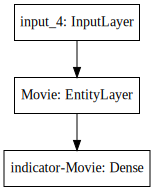

In [37]:
draw(Movie_m)

In [38]:
tt = list(zip(person,[0]*len(person)))+list(zip(movie,[1]*len(movie)))
shuffle(tt)
Xt11 = cv.transform(list(map( lambda x: x[0],tt)))
Xt1 = emb_m.predict(Xt11, verbose=1)
yt1 = np.asarray(list(map( lambda x: [x[1]],tt))).astype(int)

200000/200000 [==============================] - 114s 570us/step


In [39]:
Movie_m.fit(Xt1, yt1, epochs=10, validation_split=0.1)

Train on 180000 samples, validate on 20000 samples
Epoch 1/10
180000/180000 [==============================] - 55s 305us/step - loss: 0.1892 - acc: 0.9478 - val_loss: 0.1042 - val_acc: 0.9815
Epoch 2/10
180000/180000 [==============================] - 55s 305us/step - loss: 0.0895 - acc: 0.9850 - val_loss: 0.0833 - val_acc: 0.9846
Epoch 3/10
180000/180000 [==============================] - 55s 305us/step - loss: 0.0771 - acc: 0.9869 - val_loss: 0.0813 - val_acc: 0.9840
Epoch 4/10
180000/180000 [==============================] - 55s 305us/step - loss: 0.0729 - acc: 0.9875 - val_loss: 0.0816 - val_acc: 0.9845
Epoch 5/10
180000/180000 [==============================] - 55s 305us/step - loss: 0.0705 - acc: 0.9877 - val_loss: 0.0753 - val_acc: 0.9853
Epoch 6/10
180000/180000 [==============================] - 55s 306us/step - loss: 0.0683 - acc: 0.9881 - val_loss: 0.0742 - val_acc: 0.9850
Epoch 7/10
180000/180000 [==============================] - 55s 306us/step - loss: 0.0668 - acc: 0.9880

In [40]:
yp = Movie_m.predict(Xt1, verbose=1)
yp = (yp > 0.5).astype(int)
yp

200000/200000 [==============================] - 35s 176us/step


array([[0],
       [1],
       [1],
       ...,
       [1],
       [0],
       [1]])

In [41]:
(yp == yt1).mean()

0.98966

In [42]:
Movie_m.save('../data/snn_e_movie.model')

## Entrnanado las relaciones

In [43]:
x = Input(shape=(emb_m.output_shape[1],), sparse=True)
Person_e=EntityLayer(snn.entity_shape, name=Person.name)(x)
Movie_e=EntityLayer(snn.entity_shape, name=Movie.name)(x)
for rel in relations.values():
#rel = list(relations.values())[0]
    print('Relación: '+rel.label)
    print('-----------------------------------------------------------------------')
    Rel_r=RelationLayer(snn.relation_shape, name=rel.label)([Person_e, Movie_e])
    Rel_i=Dense(units=1, activation='sigmoid', name="indicator-%s" % rel.label)(Rel_r)
    Rel_m = Model(inputs=x, outputs=Rel_i)
    Rel_m.layers[1].set_weights(Person_m.layers[1].get_weights())
    Rel_m.layers[2].set_weights(Movie_m.layers[1].get_weights())
    Rel_m.layers[1].trainable=False
    Rel_m.layers[2].trainable=False
    Rel_m.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    print(Rel_m.summary())
    #draw(Rel_m)

    yy = [ [int(t.Relation==rel.label)] for t in df.itertuples() if t.Relation!='self']
    yt2 = np.asarray(yy)

    Rel_m.fit(Xte, yt2, epochs=10, validation_split=0.1)

    yp = Rel_m.predict(Xte, verbose=1)
    yp = (yp > 0.5).astype(int)
    print(yp)
    print((yp == yt2).mean())

    name = rel.label
    Rel_m.save('../data/snn_r_{name}.model'.format(name=name))
    print('-----------------------------------------------------------------------')

Relación: director
-----------------------------------------------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 30924)        0                                            
__________________________________________________________________________________________________
Person (EntityLayer)            (None, 32)           990656      input_5[0][0]                    
__________________________________________________________________________________________________
Movie (EntityLayer)             (None, 32)           990656      input_5[0][0]                    
__________________________________________________________________________________________________
director (RelationLayer)        (None, 64)           6272        Person[0][0]                     
                  

Train on 90000 samples, validate on 10000 samples
Epoch 1/10
90000/90000 [==============================] - 37s 409us/step - loss: 0.0584 - acc: 0.9896 - val_loss: 0.0470 - val_acc: 0.9925
Epoch 2/10
90000/90000 [==============================] - 37s 409us/step - loss: 0.0288 - acc: 0.9955 - val_loss: 0.0452 - val_acc: 0.9925
Epoch 3/10
90000/90000 [==============================] - 37s 409us/step - loss: 0.0269 - acc: 0.9961 - val_loss: 0.0453 - val_acc: 0.9926
Epoch 4/10
90000/90000 [==============================] - 37s 409us/step - loss: 0.0265 - acc: 0.9961 - val_loss: 0.0453 - val_acc: 0.9926
Epoch 5/10
90000/90000 [==============================] - 37s 409us/step - loss: 0.0262 - acc: 0.9961 - val_loss: 0.0474 - val_acc: 0.9926
Epoch 6/10
90000/90000 [==============================] - 37s 409us/step - loss: 0.0258 - acc: 0.9961 - val_loss: 0.0449 - val_acc: 0.9926
Epoch 7/10
90000/90000 [==============================] - 37s 409us/step - loss: 0.0258 - acc: 0.9962 - val_loss: 0.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 30924)        0                                            
__________________________________________________________________________________________________
Person (EntityLayer)            (None, 32)           990656      input_5[0][0]                    
__________________________________________________________________________________________________
Movie (EntityLayer)             (None, 32)           990656      input_5[0][0]                    
__________________________________________________________________________________________________
actor (RelationLayer)           (None, 64)           6272        Person[0][0]                     
                                                                 Movie[0][0]                      
__________

In [45]:
rcont={i:0 for i in relations.keys()}
for t in df.itertuples():
    if t.Relation!='self':
        rcont[t.Relation]+=1
rcont

{'director': 12342,
 'cinematographer': 6776,
 'composer': 402,
 'producer': 2724,
 'editor': 288,
 'actor': 41270,
 'actress': 23314,
 'writer': 12694,
 'production_designer': 176,
 'archive_footage': 14}